In [1]:
import pandas as pd
import numpy as np
from sklearn.metrics import roc_auc_score
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from catboost import CatBoostClassifier
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import roc_auc_score
from ydata_profiling import ProfileReport

In [3]:
#global variables

pd.set_option('display.max_columns', None)

SEED = 42

FOLDS = 5

FILEPATH = '../data/'

In [4]:
test_df = pd.read_csv(f'{FILEPATH}test.csv')
train_df = pd.read_csv(f'{FILEPATH}train.csv')

In [5]:
ProfileReport(train_df, title='Pandas Profiling Report', explorative=True).to_file("train_report.html")

Summarize dataset:   0%|          | 0/5 [00:00<?, ?it/s]

Generate report structure:   0%|          | 0/1 [00:00<?, ?it/s]

Render HTML:   0%|          | 0/1 [00:00<?, ?it/s]

Export report to file:   0%|          | 0/1 [00:00<?, ?it/s]

In [ ]:
def analyze_dataframe(df):
    """
    Analyze a pandas DataFrame and provide a summary of its characteristics.

    Parameters:
    df (pandas.DataFrame): The input DataFrame to analyze.

    Returns:
    None
    """
    print("DataFrame Information:")
    print("______________________")
    display(df.info(verbose=True, show_counts=True))
    print("\n")
    
    print("DataFrame Head:")
    print("______________________")
    display(df.head())
    print("\n")

    print("DataFrame Tail:")
    print("______________________")
    display(df.tail())
    print("\n")

    print("DataFrame Description:")
    print("______________________")
    display(df.describe().T)
    print("\n")

    print("Number of Null Values:")
    print("______________________")
    display(df.isnull().sum())
    print("\n")

    print("Number of Duplicated Rows:")
    print("______________________")
    display(df.duplicated().sum())
    print("\n")

    print("Number of Unique Values:")
    print("______________________")
    display(df.nunique())
    print("\n")

    print("DataFrame Shape:")
    print("______________________")
    print(f"Rows: {df.shape[0]}, Columns: {df.shape[1]}")
    print("\n")
    
    print("DataFrame Columns:")
    print("______________________")
    display(df.columns)
    

analyze_dataframe(train)


In [24]:
# Define the defect categories
defect_categories = ['Pastry', 'Z_Scratch', 'K_Scatch', 'Stains', 'Dirtiness', 'Bumps', 'Other_Faults']

# Split the training data into features and targets
X = train_df.drop(columns=['id'] + defect_categories)
y = train_df[defect_categories]

# Number of folds for Stratified K-Fold
n_splits = 5

# Initialize the Stratified K-Fold cross-validator
skf = StratifiedKFold(n_splits=n_splits, shuffle=True, random_state=42)

# Store the average AUC scores for each defect category
average_auc_scores = []

# Iterate over each defect category
for category in defect_categories:
    print(f"Training model for {category}...")

    # Store the AUC scores for each fold
    fold_auc_scores = []

    # Perform Stratified K-Fold cross-validation
    for fold, (train_idx, val_idx) in enumerate(skf.split(X, y[category])):
        X_train, X_val = X.iloc[train_idx], X.iloc[val_idx]
        y_train, y_val = y.iloc[train_idx][category], y.iloc[val_idx][category]

        # Train the CatBoost classifier
        model = CatBoostClassifier(verbose=False, random_seed=42, task_type="GPU")
        model.fit(X_train, y_train)

        # Make predictions and calculate AUC for the current fold
        y_pred = model.predict_proba(X_val)[:, 1]
        auc = roc_auc_score(y_val, y_pred)
        fold_auc_scores.append(auc)
        print(f"  AUC for fold {fold + 1}: {auc}")

    # Calculate the average AUC across all folds for the current defect category
    average_auc = np.mean(fold_auc_scores)
    average_auc_scores.append(average_auc)
    print(f"Average AUC for {category}: {average_auc}\n")

# Calculate the overall average AUC score across all defect categories
overall_average_auc = np.mean(average_auc_scores)
print(f"Overall Average AUC Score: {overall_average_auc}")

Training model for Pastry...
  AUC for fold 1: 0.8702523828792159
  AUC for fold 2: 0.8694248507606857


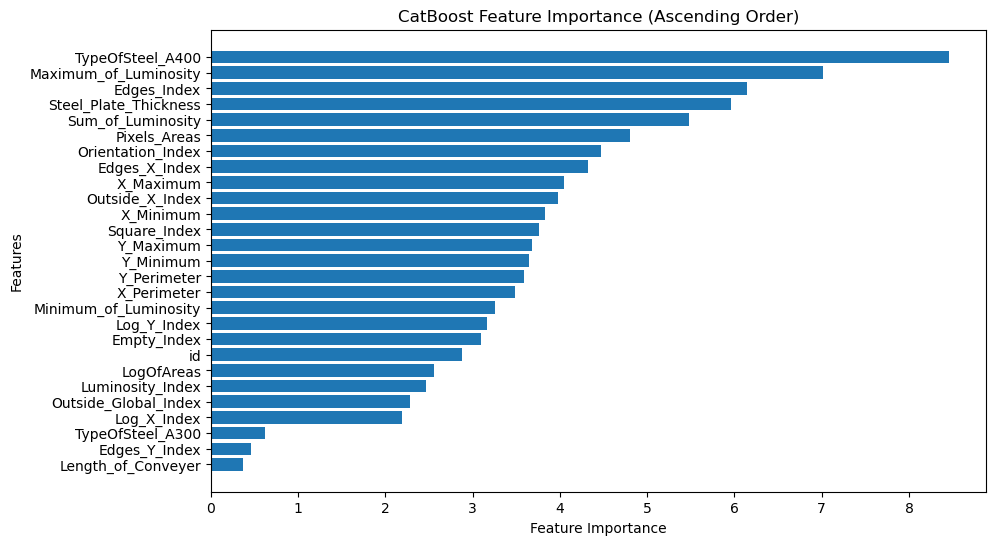

In [20]:
import matplotlib.pyplot as plt

feature_importance = model.get_feature_importance()
feature_names = train_df.drop(columns=defect_categories).columns

# Sort the feature importance and feature names in ascending order
sorted_indices = feature_importance.argsort()
sorted_feature_importance = feature_importance[sorted_indices]
sorted_feature_names = feature_names[sorted_indices]

plt.figure(figsize=(10, 6))
plt.barh(sorted_feature_names, sorted_feature_importance)
plt.xlabel('Feature Importance')
plt.ylabel('Features')
plt.title('CatBoost Feature Importance (Ascending Order)')
plt.show()


# Submission

In [17]:
final_models = {}
for category in defect_categories:
    print(f"Training final model for {category}...")
    model = CatBoostClassifier(verbose=False, random_seed=42)
    model.fit(X, y[category])
    final_models[category] = model

# Make predictions on the test data
test_predictions = pd.DataFrame({'id': test_df['id']})
for category in defect_categories:
    print(f"Predicting probabilities for {category}...")
    model = final_models[category]
    test_predictions[category] = model.predict_proba(test_df.drop(columns=['id']))[:, 1]

# Save the submission file
submission_file = 'submission.csv'
test_predictions.to_csv(submission_file, index=False)
print(f"\nSubmission file saved to: {submission_file}")

Training final model for Pastry...
Training final model for Z_Scratch...
Training final model for K_Scatch...
Training final model for Stains...
Training final model for Dirtiness...
Training final model for Bumps...
Training final model for Other_Faults...
Predicting probabilities for Pastry...
Predicting probabilities for Z_Scratch...
Predicting probabilities for K_Scatch...
Predicting probabilities for Stains...
Predicting probabilities for Dirtiness...
Predicting probabilities for Bumps...
Predicting probabilities for Other_Faults...

Submission file saved to: submission.csv
